Name: Josemaria Macedo Carrillo\
Title: Export Data Exploration\
Created: 06/22/23\
Last modified: 07/26/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports. The main data sources are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie
from utils.clean_data import PRODUCTS_VAL, translate_column
from utils.transform_data import estimate_weights
from utils.record_linkage import record_linkage, unique_matches, filter_crop

Import cleaned data from Import Genius (IG) and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
ig = get_data("ig")
bsgi = get_data("bsgi")

TypeError: 'tuple' object is not callable

In [15]:
ig["country"].unique()

print("IG tons:",ig.loc[ig.loc[:, "country"] == "індія"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "india"]["weight_ton"].sum())

array(['іспанія', 'нідерланди', 'угорщина', 'індонезія', 'алжир',
       'італія', 'бангладеш', 'словаччина', 'польща', 'молдова',
       'азербайджан', 'сполучене королівство', 'вірменія', 'казахстан',
       'грузія', 'киргизстан', 'румунія', 'чеська республіка',
       'сполучені штати америки', 'швейцарія', 'узбекистан', 'німеччина',
       'македонія колишня югославська республіка', 'ізраїль', 'уганда',
       'кувейт', 'хорватія', 'болгарія', "об'єднані арабські емірати",
       'єгипет', 'лівійська арабська джамахірія', 'бельгія', 'малайзія',
       'франція', 'корея республіка', 'кенія', 'туреччина', 'туніс',
       'китай', 'ірак', 'пакистан', 'оман', 'сенегал', 'норвегія',
       'йорданія', 'таїланд', 'латвія', 'бахрейн', 'коста-ріка', 'литва',
       'швеція', 'індія', 'палестинська територія', 'мальта', 'ліван',
       'гваделупа (фр)', 'коста ріка', 'габон', 'канада', 'сурінам',
       'об єднані арабські емірати', 'кот д івуар', 'гайана',
       'саудівська аравія', 'тай

In [16]:

kernel = ig.loc[ig.loc[:, "company_searched"] == "kernel"]

IG tons: 539844.237
BSGI tons: 585646


We group our data to plot a time series for Kernel, one of the top 10 Ukrainian
agricultural landholders with data from IG. The data goes from February 2021
until March 2023 because it was the most we could export for now with our
subscription. The horizontal axis has the export date in mm-yyyy and the
vertical axis has the total exports volume in metric tons (1,000 kilograms).

We see that there is a shift in the trend of exports in February 2022, when
Russia invaded Ukraine. This makes sense because all Black Sea ports that these
agricultural companies used where closed until the BSGI was signed in July 27,
2022. We can see there was an increase in exports but not as much as in the past.
This could be due to the lack of ports to export (only 3 ports can export at
the Black Sea and a lot of companies have to use the same ports).

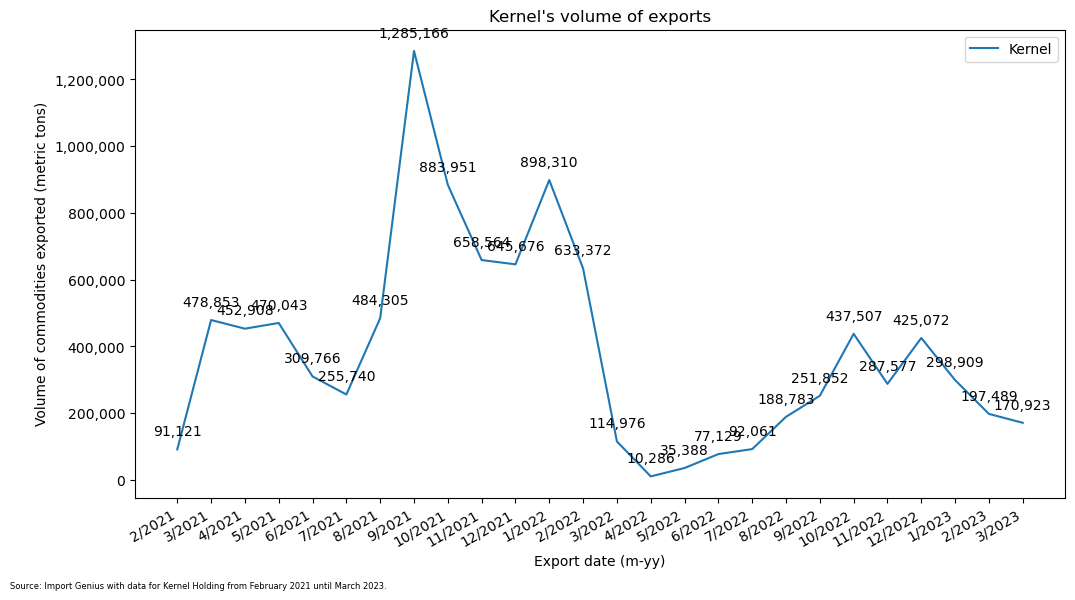

In [ ]:
kernel_g = cargo_grouping(kernel, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"})
kernel_g["date"] = kernel_g["month"].astype(str) + "/" + kernel_g["year"].astype(str)
plot_line(kernel_g["date"], [kernel_g["weight_ton"]], ["Kernel"], "Kernel's volume of exports", "Export date (m-yy)", "Volume of commodities exported (metric tons)", "Import Genius with data for Kernel Holding from February 2021 until March 2023", False)

Now we compare Kernel's exports with the overall exports in the ports from the
BSGI by plotting another time series. The horizontal axis has the export date in
mm-yyyy and the vertical axis has the total exports volume in metric tons
(1,000 kilograms).

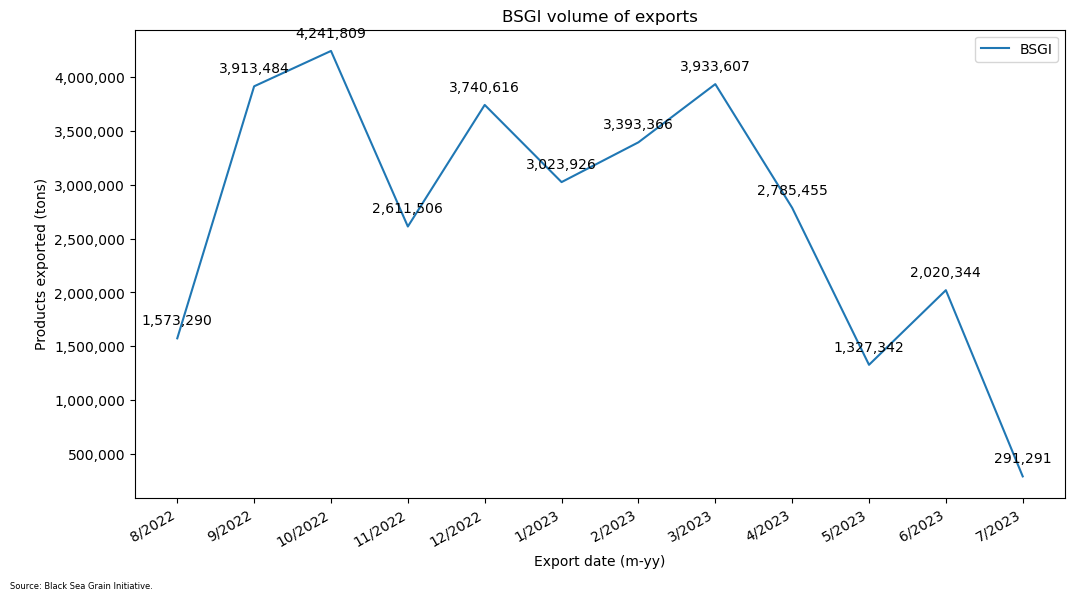

In [ ]:
bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
plot_line(bsgi_g["date"], [bsgi_g["weight_ton"]], ["BSGI"], "BSGI volume of exports", "Export date (m-yy)", "Products exported (tons)", "Black Sea Grain Initiative", False)

We plot both time series together in the same period (from August 2022 when the
BSGI started) to compare the trends from Kernel and the BSGI more closely. We
see that Kernel's exports have a similar trend than the BSGI total exports except
for the last months of February and March where Kernel's exports decrease and
BSGI's exports increase.

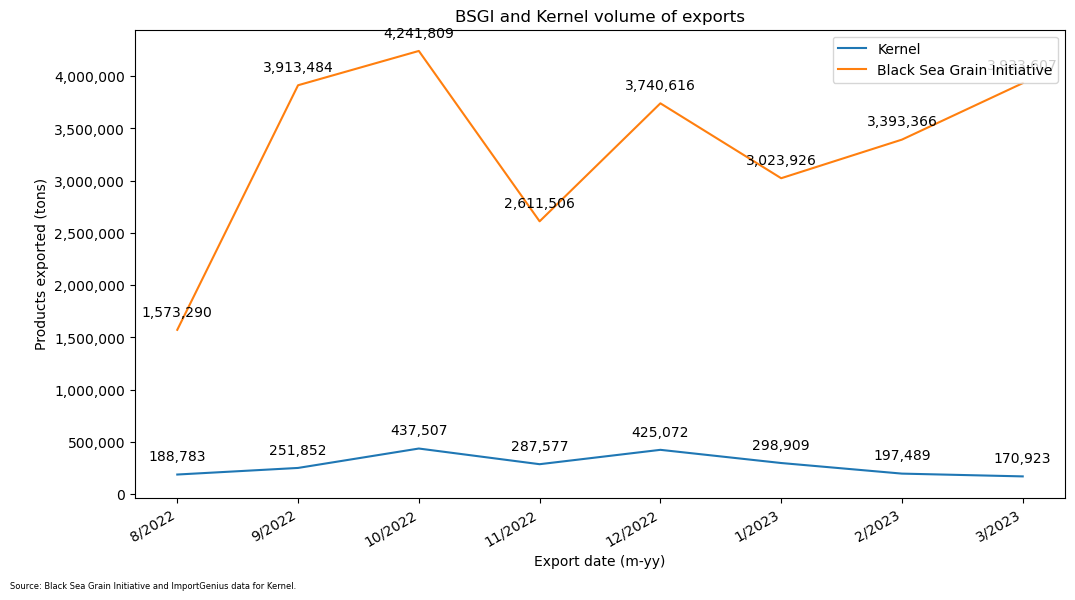

In [ ]:
final = kernel_g.merge(bsgi_g, on="date", suffixes=("_kernel", "_bsgi"))
plot_line(final["date"], [final["weight_ton_kernel"], final["weight_ton_bsgi"]], ["Kernel", "Black Sea Grain Initiative"], "BSGI and Kernel volume of exports", "Export date (m-yy)", "Products exported (tons)", "Black Sea Grain Initiative and ImportGenius data for Kernel", False)

Here we plot the same time series as before but for each of the crop categories
of the BSGI to compare the volumes of Kernel compared to the BSGI total volumes
in specific crops an get a sense of the size of Kernel's exports.

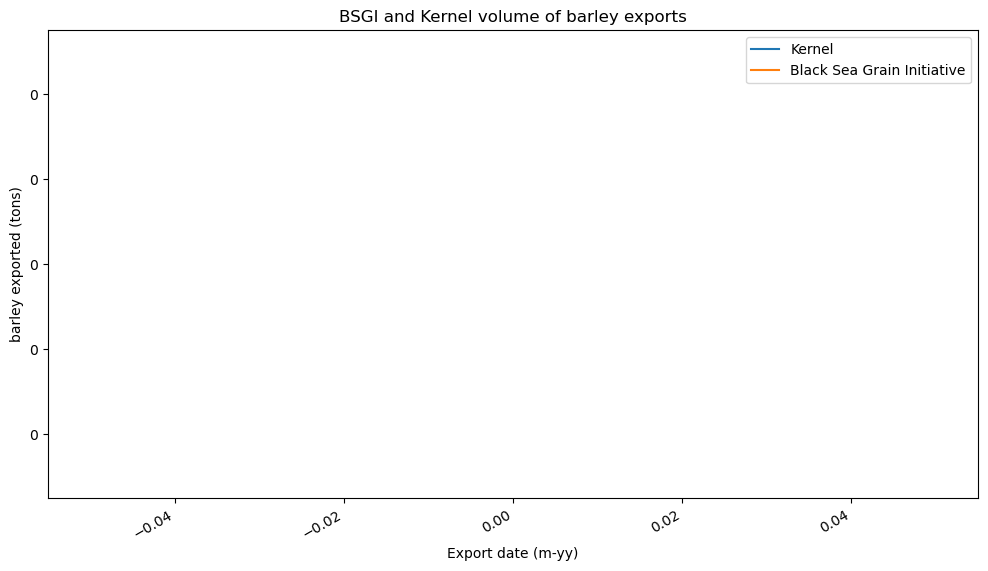

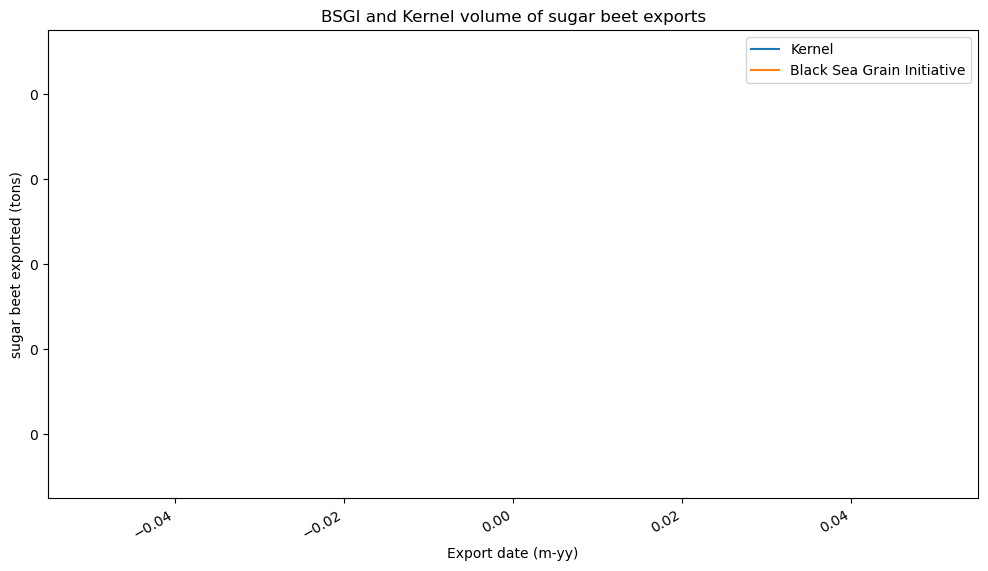

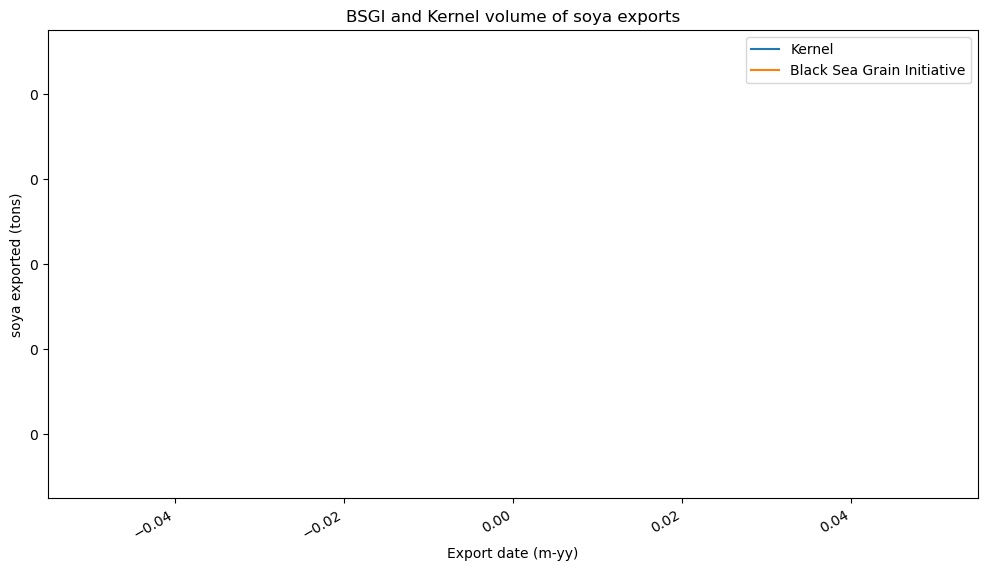

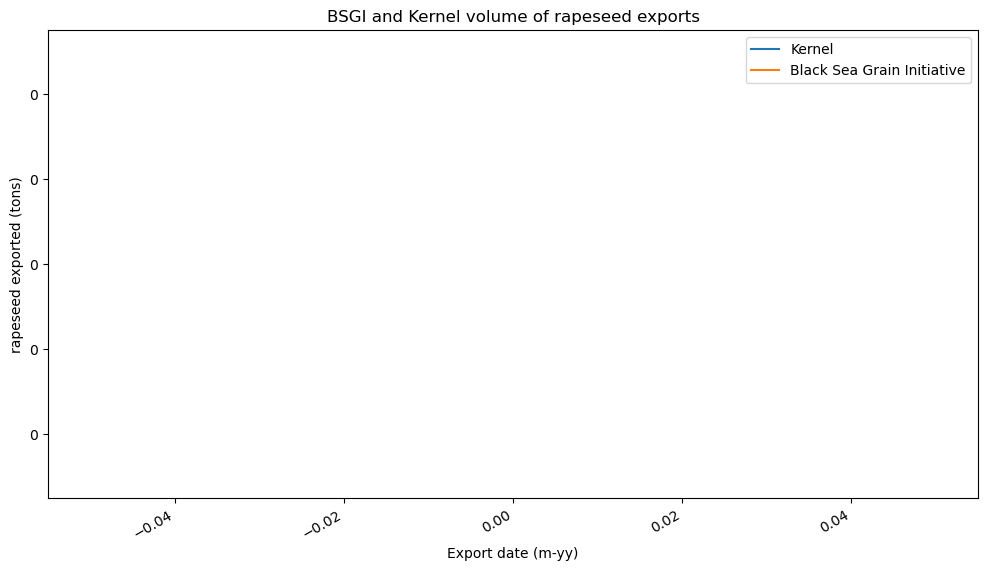

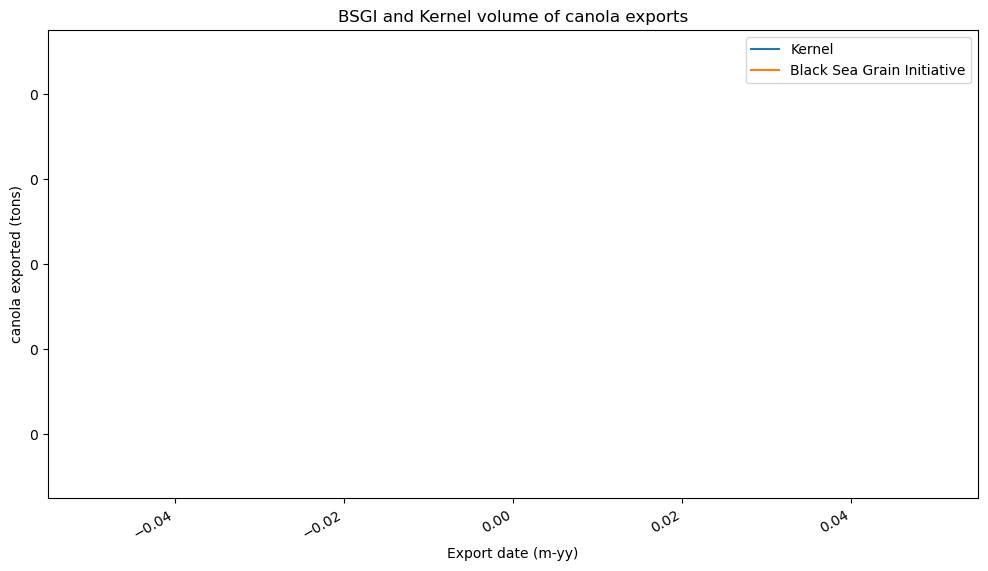

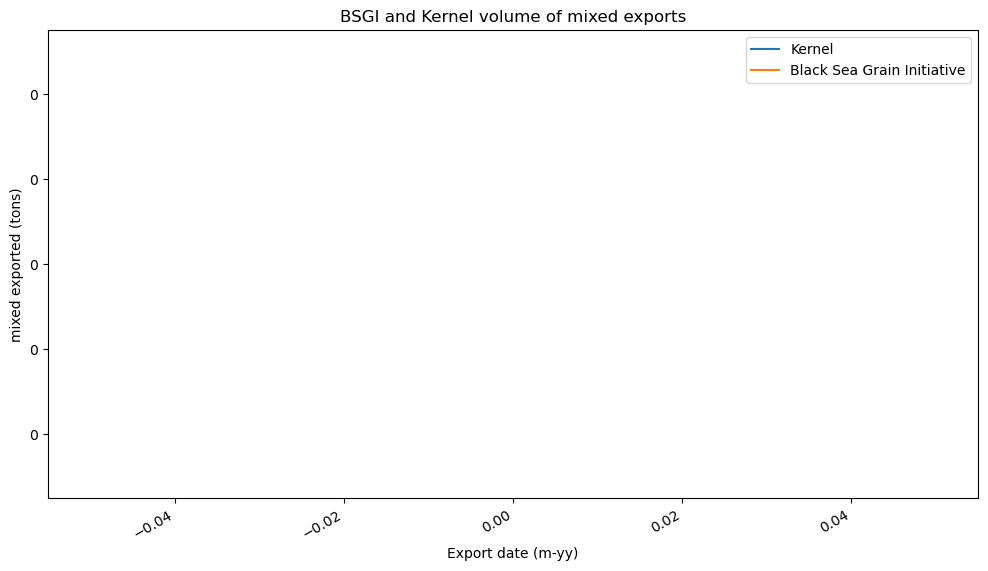

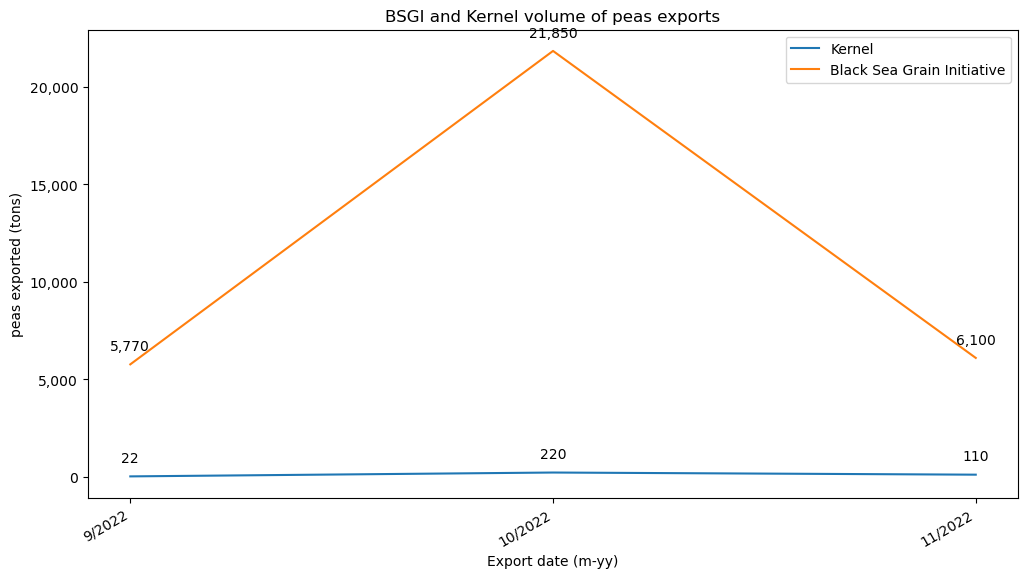

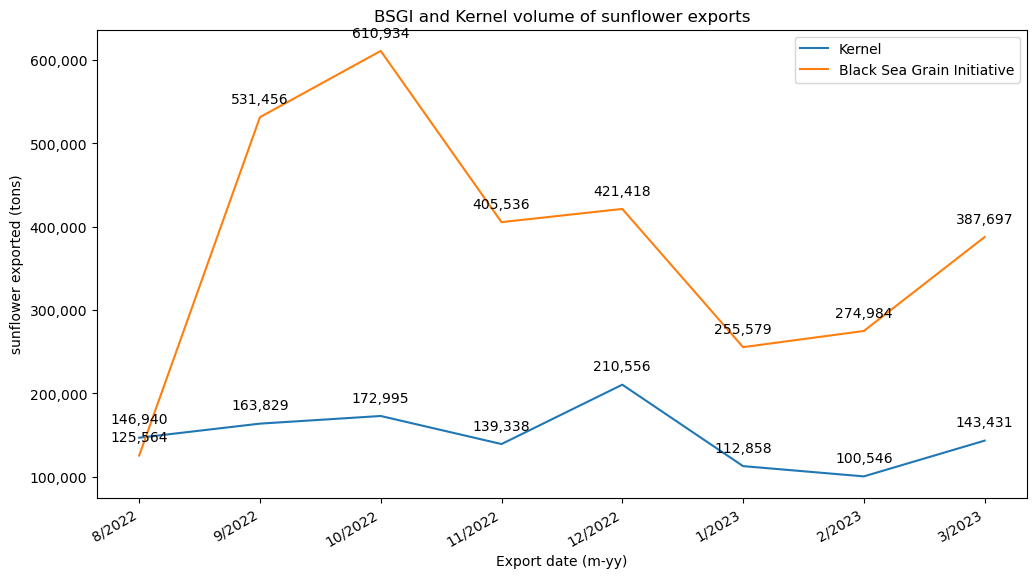

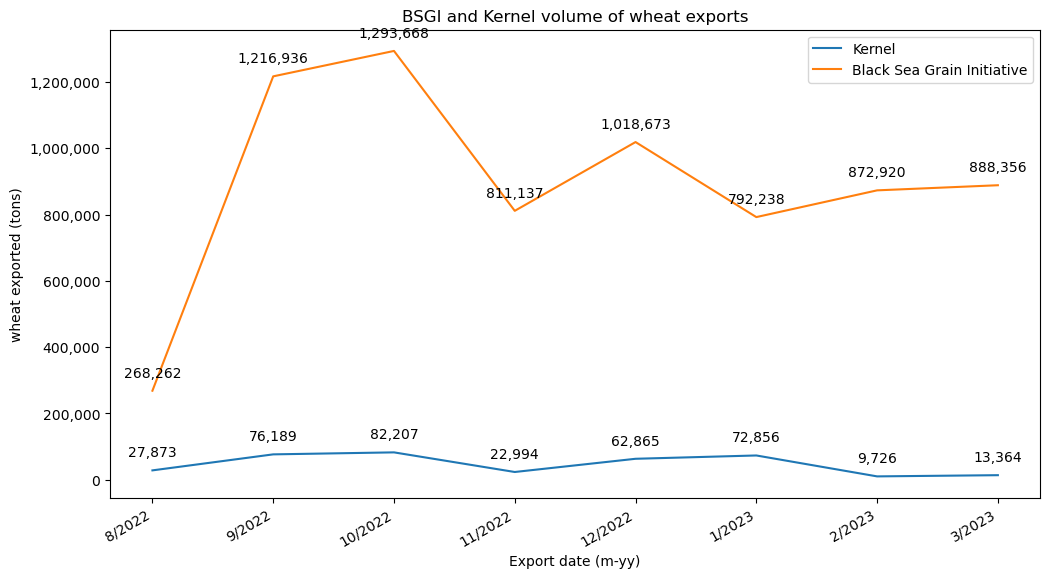

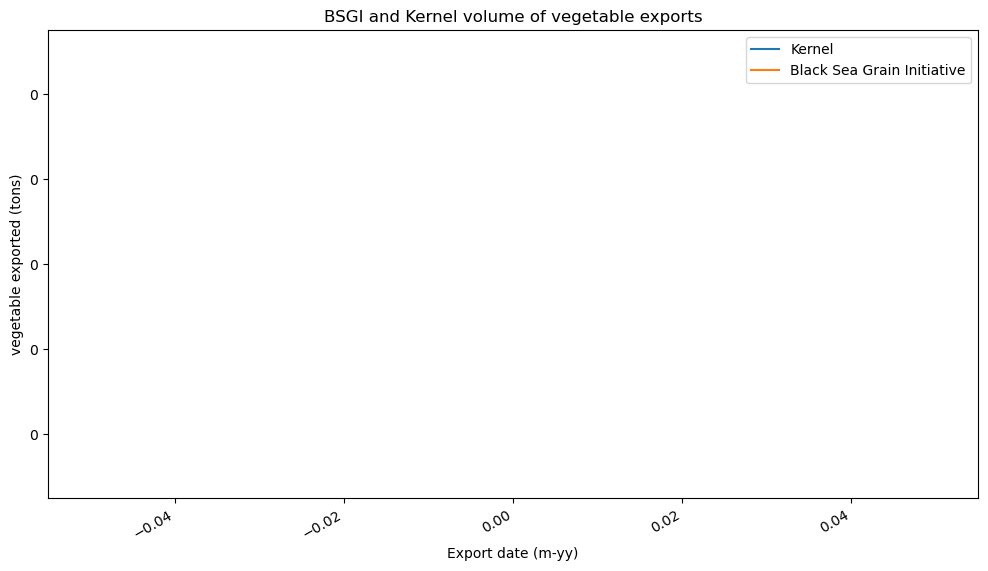

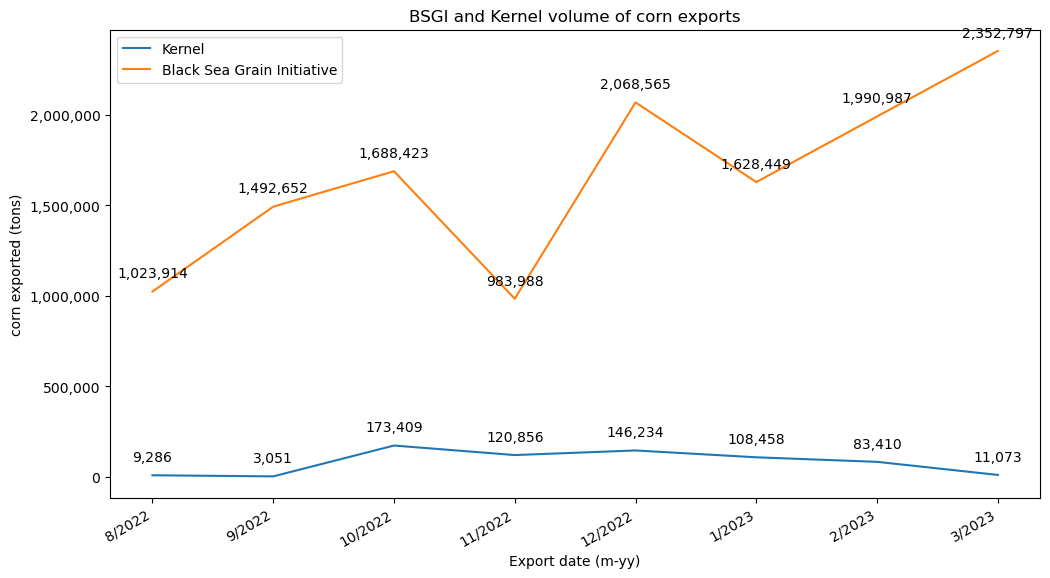

In [ ]:
product_std = set(PRODUCTS_VAL)

for crop in product_std:
    plot_crops(crop, kernel, bsgi, False)

We start doing some record matching to see if we can merge the BSGI and the IG
data based on export date, country of destination and the exported product.

In [ ]:
unique_match = rl_ig_bsgi(ig, bsgi, "sunflower", ["date"], ["country"], ["date"])
unique_match[["df_1", "df_2", "date_x", "date_y", "product_std", "country_en", "weight_ton_x", "weight_ton_y"]]

Number of matches:  16


,df_1,df_2,date_x,date_y,product_std,country_en,weight_ton_x,weight_ton_y
0,2008,1122,2022-08-17,2022-08-17,sunflower,the netherlands,59.6160,18500
1,2065,1070,2022-09-02,2022-09-02,sunflower,india,19000.0000,21000
2,2078,1046,2022-09-06,2022-09-06,sunflower,italy,20.0192,5800
3,2116,989,2022-09-15,2022-09-15,sunflower,the netherlands,20.1204,3600
4,2119,985,2022-09-15,2022-09-15,sunflower,italy,20.0192,5750
5,2133,953,2022-09-19,2022-09-19,sunflower,italy,19.4304,4400
6,2150,919,2022-09-23,2022-09-23,sunflower,romania,5723.3380,11950
7,2172,876,2022-09-28,2022-09-28,sunflower,italy,20.0192,5350
8,2313,710,2022-10-25,2022-10-25,sunflower,romania,59.6160,4000
9,2316,707,2022-10-25,2022-10-25,sunflower,spain,6300.0000,6300


Estimate the share of exports of sunflower products for Kernel.

In [ ]:
# Option 2
ig_oct_g = unique_match["weight_ton_x"].sum()
bsgi_weight = filter_crop(bsgi, "sunflower", "bsgi")["weight_ton"].sum()
other = bsgi_weight - ig_oct_g

d = {"company":["Kernel", "Other"], "weight":[ig_oct_g, other]}
df = pd.DataFrame(data=d)
df

# df = estimate_weights(unique_match, "weight_ton_x", bsgi, "weight_ton", "sunflower")

plot_pie(df["company"], df["weight"], "Company category", "Sunflower volume (metric tons) exported by company category", "ImportGenius with data for Kernel and Black Sea Grain Initiative")

NameError: name 'unique_match' is not defined

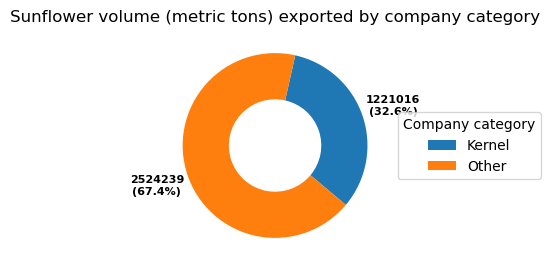

In [ ]:
# We can also sum all sunflower exports of Kernel in the IG and divide them by the total sunflower exports from BSGI but this doesn't make a lot of sense
# if we suspect that companies can export by other ports
ig_filt = ig.loc[ig.loc[:, "date"] >= "2022-08-03"]

# df = estimate_weights(ig_filt, "weight_ton", bsgi, "weight_ton", "sunflower")
# plot_pie(df["company"], df["weight"], "Company category", "Sunflower volume (metric tons) exported by company category")

ig_oct_g = filter_crop(ig_filt, "sunflower", "ig")["weight_ton"].sum()
bsgi_weight = filter_crop(bsgi, "sunflower", "bsgi")["weight_ton"].sum()
other = bsgi_weight - ig_oct_g

d = {"company":["Kernel", "Other"], "weight":[ig_oct_g, other]}
df = pd.DataFrame(data=d)
df

plot_pie(df["company"], df["weight"], "Company category", "Sunflower volume (metric tons) exported by company category")




In [ ]:
# Group IG data
kernel_c = kernel.copy()
kernel_c["hs_code_4"] = kernel_c["hs_code"].str[:4]
kernel_c = kernel_c.rename(columns={"hs_code_4": "hs_code", "hs_code": "hs_code_10"})

# Set index as column
kernel_c = kernel_c.reset_index()
kernel_g = kernel_c.loc[:, ["index", "date", "country", "weight_ton", "product", "hs_code"]].groupby(["date", "country"], as_index=False)

# Aggregate weight, hs code and product
kernel_weight = kernel_g.agg({"weight_ton": "sum", "date": "count", "index": tuple, "hs_code": tuple}).rename(columns={"date": "n_ships_ig", "index": "indexes_ig"})
kernel_product = kernel_g["product"].apply(lambda x : ' // '.join(x))

# Join aggregated dataframes in on df
kernel_final = kernel_weight.join(kernel_product, rsuffix = "_product")
kernel_final = kernel_final[["indexes_ig", "date", "country", "weight_ton", "n_ships_ig", "hs_code", "product"]]

full_unique = unique_matches(kernel_final, bsgi, ["date"], ["country"], ["date"])
# # translate_column(full_unique, "product_x", "google", "uk", "en")
full_unique = full_unique[["indexes_ig", "df_1", "df_2", "date_x", "date_y", "n_ships_ig", "hs_code_x", "hs_code_y", "product_x", "product_y", "country_x", "country_y", "country_en", "weight_ton_x", "weight_ton_y"]]
full_unique

Number of matches:  99


,indexes_ig,df_1,df_2,date_x,date_y,n_ships_ig,hs_code_x,hs_code_y,product_x,product_y,country_x,country_y,country_en,weight_ton_x,weight_ton_y
0,"(3223,)",2386,1140,2022-08-05,2022-08-05,1,"(1512,)",1005,"олії соняшникова, сафлорова або бавовняна та ї...",corn,італія,італія,italy,20.01920,13041
1,"(3193,)",2393,1133,2022-08-08,2022-08-08,1,"(2923,)",1201,солі та гідроксиди амонію четвертинні; лецитин...,soya beans,італія,італія,italy,23.96000,11000
2,"(3005, 3006, 3009)",2425,1122,2022-08-17,2022-08-17,3,"(1512, 1512, 1512)",2306,"олії соняшникова, сафлорова або бавовняна та ї...",sunflower meal,нідерланди,нідерланди,the netherlands,59.61600,18500
3,"(2889, 2890)",2458,1107,2022-08-24,2022-08-24,2,"(1512, 1512)",1205,"олії соняшникова, сафлорова або бавовняна та ї...",rapeseed,нідерланди,нідерланди,the netherlands,49.91000,29600
4,"(2820,)",2474,1089,2022-08-29,2022-08-29,1,"(1512,)",1005,"олії соняшникова, сафлорова або бавовняна та ї...",corn,румунія,румунія,romania,4892.83400,24485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"(261,)",3374,228,2023-03-14,2023-03-14,1,"(1005,)",1512,кукурудза: - інша,sunflower oil,іспанія,іспанія,spain,1193.55800,15300
95,"(210, 215, 224, 226, 227, 230)",3382,216,2023-03-16,2023-03-16,6,"(3823, 1512, 1512, 1512, 1512, 1512)",1005,промислові монокарбонові жирні кислоти; кислот...,corn,нідерланди,нідерланди,the netherlands,121.51662,66000
96,"(194, 195)",3389,208,2023-03-18,2023-03-18,2,"(1512, 1512)",1005,"олії соняшникова, сафлорова або бавовняна та ї...",corn,китай,китай,china,11581.39600,66564
97,"(75, 76)",3419,178,2023-03-27,2023-03-27,2,"(2306, 2306)",1005,"макуха та інші тверді відходи і залишки, одерж...",corn,китай,китай,china,60468.43700,65315


In [ ]:
sum(full_unique["hs_code_y"].isin(full_unique["hs_code_x"]))

0

In [ ]:
full_unique.loc[full_unique.loc[:, "df_2"] == 1122]

,indexes_ig,df_1,df_2,date_x,date_y,n_ships_ig,hs_code_x,hs_code_y,product_x,product_y,country_x,country_y,country_en,weight_ton_x,weight_ton_y
2,"(3005, 3006, 3009)",2425,1122,2022-08-17,2022-08-17,3,"(1512, 1512, 1512)",2306,"олії соняшникова, сафлорова або бавовняна та ї...",sunflower meal,нідерланди,нідерланди,the netherlands,59.616,18500


In [ ]:
# Group IG data
kernel_c = kernel.copy()
kernel_c["hs_code_4"] = kernel_c["hs_code"].str[:4]
kernel_c = kernel_c.rename(columns={"hs_code_4": "hs_code", "hs_code": "hs_code_10"})

# Set index as column
kernel_c = kernel_c.reset_index()
kernel_g = kernel_c.loc[:, ["index", "date", "country", "weight_ton", "product", "hs_code"]].groupby(["date", "country"], as_index=False)

# Aggregate weight, hs code and product
kernel_weight = kernel_g.agg({"weight_ton": "sum", "date": "count", "index": tuple, "hs_code": tuple}).rename(columns={"date": "n_ships_ig", "index": "indexes_ig"})
kernel_product = kernel_g["product"].apply(lambda x : ' // '.join(x))

# Join aggregated dataframes in on df
kernel_final = kernel_weight.join(kernel_product, rsuffix = "_product")
kernel_final = kernel_final[["indexes_ig", "date", "country", "weight_ton", "n_ships_ig", "hs_code", "product"]]

full_unique = unique_matches(kernel_final, bsgi, ["date"], ["country"], ["date"])
# # translate_column(full_unique, "product_x", "google", "uk", "en")
full_unique = full_unique[["indexes_ig", "df_1", "df_2", "date_x", "date_y", "n_ships_ig", "hs_code_x", "hs_code_y", "product_x", "product_y", "country_x", "country_y", "country_en", "weight_ton_x", "weight_ton_y"]]
full_unique

Number of matches:  99


,indexes_ig,df_1,df_2,date_x,date_y,n_ships_ig,hs_code_x,hs_code_y,product_x,product_y,country_x,country_y,country_en,weight_ton_x,weight_ton_y
0,"(3223,)",2386,1140,2022-08-05,2022-08-05,1,"(1512,)",1005,"олії соняшникова, сафлорова або бавовняна та ї...",corn,італія,італія,italy,20.01920,13041
1,"(3193,)",2393,1133,2022-08-08,2022-08-08,1,"(2923,)",1201,солі та гідроксиди амонію четвертинні; лецитин...,soya beans,італія,італія,italy,23.96000,11000
2,"(3005, 3006, 3009)",2425,1122,2022-08-17,2022-08-17,3,"(1512, 1512, 1512)",2306,"олії соняшникова, сафлорова або бавовняна та ї...",sunflower meal,нідерланди,нідерланди,the netherlands,59.61600,18500
3,"(2889, 2890)",2458,1107,2022-08-24,2022-08-24,2,"(1512, 1512)",1205,"олії соняшникова, сафлорова або бавовняна та ї...",rapeseed,нідерланди,нідерланди,the netherlands,49.91000,29600
4,"(2820,)",2474,1089,2022-08-29,2022-08-29,1,"(1512,)",1005,"олії соняшникова, сафлорова або бавовняна та ї...",corn,румунія,румунія,romania,4892.83400,24485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"(261,)",3374,228,2023-03-14,2023-03-14,1,"(1005,)",1512,кукурудза: - інша,sunflower oil,іспанія,іспанія,spain,1193.55800,15300
95,"(210, 215, 224, 226, 227, 230)",3382,216,2023-03-16,2023-03-16,6,"(3823, 1512, 1512, 1512, 1512, 1512)",1005,промислові монокарбонові жирні кислоти; кислот...,corn,нідерланди,нідерланди,the netherlands,121.51662,66000
96,"(194, 195)",3389,208,2023-03-18,2023-03-18,2,"(1512, 1512)",1005,"олії соняшникова, сафлорова або бавовняна та ї...",corn,китай,китай,china,11581.39600,66564
97,"(75, 76)",3419,178,2023-03-27,2023-03-27,2,"(2306, 2306)",1005,"макуха та інші тверді відходи і залишки, одерж...",corn,китай,китай,china,60468.43700,65315


In [ ]:
kernel_sunflower = filter_crop(kernel, "sunflower", "ig")
kernel_sunflower.sort_values(by=["date"], ascending=True)

,product,hs_code,consignee,consignee_address,shipper,shipper_address,date,quantity,weight_kg,invoice_price_uah,...,barley,corn,rapeseed,canola,mixed,sunflower,wheat,peas,sugar beet,soya
9999,"макуха та інші тверді відходи і залишки, одерж...",2306300000,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ АГРОГ...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 УКРАЇНА М КИЇВ ПРОВ ШЕВ...,NaN,2021-02-25,NaN,123750.00,1.060847e+06,...,False,False,False,False,False,True,False,False,False,False
9984,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,SIA KONDIS RIGAS RAJ GARKALNES NOV BUKULTI VET...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2021-02-25,NaN,10350.00,4.191750e+05,...,False,False,False,False,False,True,False,False,False,False
9987,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КЕРНЕЛ...,NaN,2021-02-25,NaN,4390847.00,1.146406e+08,...,False,False,False,False,False,True,False,False,False,False
9988,"олії соняшникова, сафлорова або бавовняна та ї...",1512119100,INERCO TRADE S A RUE JULES GACHET 9 1260 NYON ...,NaN,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КЕРНЕЛ...,NaN,2021-02-25,NaN,3903185.00,1.019083e+08,...,False,False,False,False,False,True,False,False,False,False
9989,"олії соняшникова, сафлорова або бавовняна та ї...",1512199010,C I V SUPERUNIE B A THE NETHERLANDS INDUSTRIEW...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2021-02-25,NaN,19872.00,7.949019e+05,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,"олії соняшникова, сафлорова або бавовняна та ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,24380.00,1.041450e+06,...,False,False,False,False,False,True,False,False,False,False
22,"олії соняшникова, сафлорова або бавовняна та ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,24840.00,1.044900e+06,...,False,False,False,False,False,True,False,False,False,False
23,"олії соняшникова, сафлорова або бавовняна та ї...",1512199010,SENAME SARL NO3 ILOT I SCAT URBAM HANN MARISTE...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23912.64,1.005890e+06,...,False,False,False,False,False,True,False,False,False,False
12,"олії соняшникова, сафлорова або бавовняна та ї...",1512199010,OMANI GULF FOOD COMPANY LLC P O BOX 43 P C 217...,NaN,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,NaN,2023-03-31,NaN,23990.00,7.556850e+05,...,False,False,False,False,False,True,False,False,False,False
